<!--NAVIGATION-->
< [Combining Datasets: Merge and Join](03.07-Merge-and-Join.ipynb) | [Contents](Index.ipynb) | [Pivot Tables](03.09-Pivot-Tables.ipynb) >

# Aggregation and Grouping

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

For convenience, we'll use the same ``display`` magic function that we've seen in previous sections:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/) (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [3]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [5]:
planets.ndim

2

In [11]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
method            1035 non-null object
number            1035 non-null int64
orbital_period    992 non-null float64
mass              513 non-null float64
distance          808 non-null float64
year              1035 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [8]:
planets.describe()

,number,orbital_period,mass,distance,year
count,1035.000000,992.000000,513.000000,808.000000,1035.000000
mean,1.785507,2002.917596,2.638161,264.069282,2009.070531
std,1.240976,26014.728304,3.818617,733.116493,3.972567
min,1.000000,0.090706,0.003600,1.350000,1989.000000
25%,1.000000,5.442540,0.229000,32.560000,2007.000000
50%,1.000000,39.979500,1.260000,55.250000,2010.000000
75%,2.000000,526.005000,3.040000,178.500000,2012.000000
max,7.000000,730000.000000,25.000000,8500.000000,2014.000000


In [13]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [14]:
planets.tail()

,method,number,orbital_period,mass,distance,year
1030,Transit,1,3.941507,NaN,172.0,2006
1031,Transit,1,2.615864,NaN,148.0,2007
1032,Transit,1,3.191524,NaN,174.0,2007
1033,Transit,1,4.125083,NaN,293.0,2008
1034,Transit,1,4.187757,NaN,260.0,2008


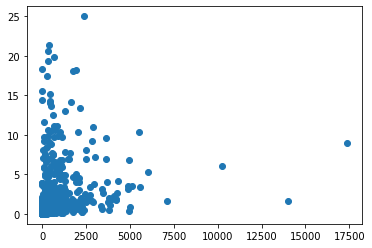

In [15]:
op = planets['orbital_period']
m = planets['mass']
plt.scatter(op,m)

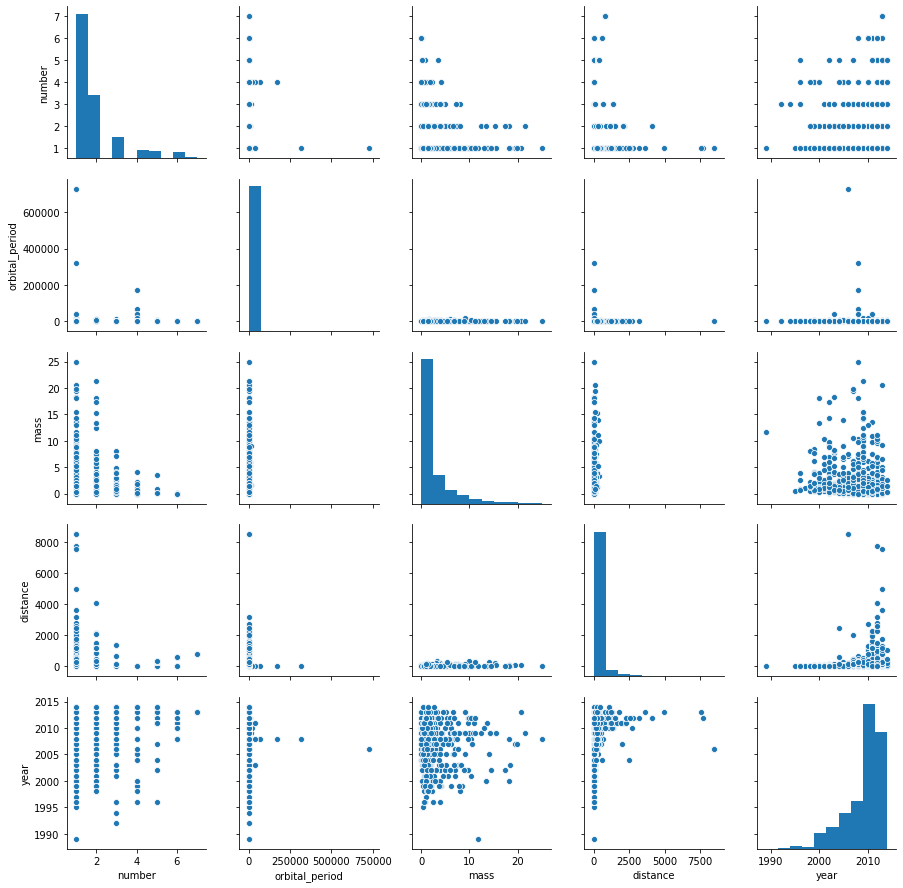

In [17]:
sns.pairplot(planets)

This has some details on the 1,000+ extrasolar planets discovered up to 2014.

## Simple Aggregation in Pandas

Earlier, we explored some of the data aggregations available for NumPy arrays (["Aggregations: Min, Max, and Everything In Between"](02.04-Computation-on-arrays-aggregates.ipynb)).
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [18]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [19]:
ser.sum()

2.811925491708157

In [20]:
ser.mean()

0.5623850983416314

In [21]:
ser.median()

0.5986584841970366

In [22]:
ser.max()

0.9507143064099162

In [23]:
ser.var()

0.09532548164256274

In [24]:
ser.min()

0.15601864044243652

In [25]:
ser.count()

5

In [26]:
ser.std()

0.30874824961862174

For a ``DataFrame``, by default the aggregates return results within each column:

In [27]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [28]:
df.sum()

A    2.389442
B    2.217101
dtype: float64

In [29]:
df.max()

A    0.866176
B    0.969910
dtype: float64

In [30]:
df.min()

A    0.058084
B    0.020584
dtype: float64

In [31]:
df.median()

A    0.601115
B    0.212339
dtype: float64

In [32]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

In [33]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

In [34]:
Date= pd.date_range('2019-08-27', periods=10, freq='3D')
ts = pd.DataFrame({'A': [1,2,3,4,6,7,8,9,10,11]}, index=Date)
print(ts,"Data Sets")

             A
2019-08-27   1
2019-08-30   2
2019-09-02   3
2019-09-05   4
2019-09-08   6
2019-09-11   7
2019-09-14   8
2019-09-17   9
2019-09-20  10
2019-09-23  11 Data Sets


In [35]:
print(ts.first('7D'),"First Data")
print(ts.last('3D'),"Last Data")

            A
2019-08-27  1
2019-08-30  2
2019-09-02  3 First Data
             A
2019-09-23  11 Last Data


By specifying the ``axis`` argument, you can instead aggregate within each row:

Pandas ``Series`` and ``DataFrame``s include all of the common aggregates mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb); in addition, there is a convenience method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [36]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These are all methods of ``DataFrame`` and ``Series`` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

![](figures/03.08-split-apply-combine.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Split-Apply-Combine)

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [37]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(7,13)}, columns=['key', 'data'])
df

,key,data
0,A,7
1,B,8
2,C,9
3,A,10
4,B,11
5,C,12


The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [39]:
a = df.groupby('key')
a

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [41]:
df.groupby('key').sum()

,data
key,
A,17
B,19
C,21


The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

In [42]:
df.groupby('key').mean()

,data
key,
A,8.5
B,9.5
C,10.5


In [43]:
df.groupby('key').var()

,data
key,
A,4.5
B,4.5
C,4.5


### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in ["Aggregate, Filter, Transform, Apply"](#Aggregate,-Filter,-Transform,-Apply), but before that let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [44]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [45]:
planets.groupby('method')

In [46]:
planets.groupby('method')['orbital_period']

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [47]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

In [48]:
planets.groupby('method')['orbital_period'].mean()

method
Astrometry                          631.180000
Eclipse Timing Variations          4751.644444
Imaging                          118247.737500
Microlensing                       3153.571429
Orbital Brightness Modulation         0.709307
Pulsar Timing                      7343.021201
Pulsation Timing Variations        1170.000000
Radial Velocity                     823.354680
Transit                              21.102073
Transit Timing Variations            79.783500
Name: orbital_period, dtype: float64

In [49]:
planets.groupby('method')['orbital_period'].std()

method
Astrometry                          544.217663
Eclipse Timing Variations          2499.130945
Imaging                          213978.177277
Microlensing                       1113.166333
Orbital Brightness Modulation         0.725493
Pulsar Timing                     16313.265573
Pulsation Timing Variations                NaN
Radial Velocity                    1454.926210
Transit                              46.185893
Transit Timing Variations            71.599884
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [54]:
for (method, group) in planets.groupby('method'):
    #print(method)
    #print(group)
    print("{0:50} shape={1}".format(method, group.shape))

Astrometry                                         shape=(2, 6)
Eclipse Timing Variations                          shape=(9, 6)
Imaging                                            shape=(38, 6)
Microlensing                                       shape=(23, 6)
Orbital Brightness Modulation                      shape=(3, 6)
Pulsar Timing                                      shape=(5, 6)
Pulsation Timing Variations                        shape=(1, 6)
Radial Velocity                                    shape=(553, 6)
Transit                                            shape=(397, 6)
Transit Timing Variations                          shape=(4, 6)


This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [56]:
planets.stack()

0     method            Radial Velocity
      number                          1
      orbital_period              269.3
      mass                          7.1
      distance                     77.4
                             ...       
1034  method                    Transit
      number                          1
      orbital_period            4.18776
      distance                      260
      year                         2008
Length: 5418, dtype: object

In [57]:
planets.unstack()

method  0       Radial Velocity
        1       Radial Velocity
        2       Radial Velocity
        3       Radial Velocity
        4       Radial Velocity
                     ...       
year    1030               2006
        1031               2007
        1032               2007
        1033               2008
        1034               2008
Length: 6210, dtype: object

In [59]:
planets.groupby('method').describe().stack()

number  orbital_period  mass     distance  \
method                                                                       
Astrometry                count    2.00        2.000000   0.0     2.000000   
                          mean     1.00      631.180000   NaN    17.875000   
                          std      0.00      544.217663   NaN     4.094148   
                          min      1.00      246.360000   NaN    14.980000   
                          25%      1.00      438.770000   NaN    16.427500   
...                                 ...             ...   ...          ...   
Transit Timing Variations min      2.00       22.339500   NaN   339.000000   
                          25%      2.00       39.675250   NaN   597.000000   
                          50%      2.00       57.011000   NaN   855.000000   
                          75%      2.25      108.505500   NaN  1487.000000   
                          max      3.00      160.000000   NaN  2119.000000   

                                       year  
method                                       
Astrometry                count     2.00000  
                          mean   2011.50000  
                          std       2.12132  
                          min    2010.00000  
                          25%    2010.75000  
...                                     ...  
Transit Timing Variations min    2011.00000  
                          25%    2011.75000  
                          50%    2012.50000  
                          75%    2013.25000  
                          max    2014.00000  

[79 rows x 5 columns]

In [60]:
planets.groupby('method').describe().unstack()

               method                       
number  count  Astrometry                          2.0
               Eclipse Timing Variations           9.0
               Imaging                            38.0
               Microlensing                       23.0
               Orbital Brightness Modulation       3.0
                                                 ...  
year    max    Pulsar Timing                    2011.0
               Pulsation Timing Variations      2007.0
               Radial Velocity                  2014.0
               Transit                          2014.0
               Transit Timing Variations        2014.0
Length: 400, dtype: float64

Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [61]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(14,20),
                   'data2': rng.randint(1, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,14,6
1,B,15,1
2,C,16,4
3,A,17,4
4,B,18,8
5,C,19,4


#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [63]:
df.groupby('key').aggregate(['min', np.median, 'max',np.mean,np.std,np.var])

data1                                data2                                
      min median max  mean      std  var   min median max mean       std   var
key                                                                           
A      14   15.5  17  15.5  2.12132  4.5     4    5.0   6  5.0  1.414214   2.0
B      15   16.5  18  16.5  2.12132  4.5     1    4.5   8  4.5  4.949747  24.5
C      16   17.5  19  17.5  2.12132  4.5     4    4.0   4  4.0  0.000000   0.0

Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [64]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,14,6
B,15,8
C,16,4


#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [67]:
def filter_func(x):
    #print(x)
    return x['data2'].std() >4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A     14      6
1   B     15      1
2   C     16      4
3   A     17      4
4   B     18      8
5   C     19      4

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  0.000000

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B     15      1
4   B     18      8

In [68]:
df.groupby('key').std()

,data1,data2
key,,
A,2.12132,1.414214
B,2.12132,4.949747
C,2.12132,0.000000


In [69]:
df.groupby('key').filter(filter_func)

,key,data1,data2
1,B,15,1
4,B,18,8


The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [70]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,0.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,0.0


#### The apply() method

The ``apply()`` method lets you apply an arbitrary function to the group results.
The function should take a ``DataFrame``, and return either a Pandas object (e.g., ``DataFrame``, ``Series``) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an ``apply()`` that normalizes the first column by the sum of the second:

In [71]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] += x['data2'].sum()   
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,14,6
1,B,15,1
2,C,16,4
3,A,17,4
4,B,18,8
5,C,19,4
,key,data1,data2
0,A,24,6
1,B,24,1
2,C,24,4


In [72]:
df.groupby('key').apply(norm_by_data2)

,key,data1,data2
0,A,24,6
1,B,24,1
2,C,24,4
3,A,27,4
4,B,27,8
5,C,27,4


``apply()`` within a ``GroupBy`` is quite flexible: the only criterion is that the function takes a ``DataFrame`` and returns a Pandas object or scalar; what you do in the middle is up to you!

### Specifying the split key

In the simple examples presented before, we split the ``DataFrame`` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the ``DataFrame``. For example:

In [73]:
df

,key,data1,data2
0,A,14,6
1,B,15,1
2,C,16,4
3,A,17,4
4,B,18,8
5,C,19,4


In [74]:
L = [0, 1, 2, 1, 2, 0]   # 0-->0 
#L = [0,1,2,0,1,2]
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A     14      6
1   B     15      1
2   C     16      4
3   A     17      4
4   B     18      8
5   C     19      4

df.groupby(L).sum()
   data1  data2
0     33     10
1     32      5
2     34     12

In [75]:
df.groupby(L).sum()

,data1,data2
0,33,10
1,32,5
2,34,12


Of course, this means there's another, more verbose way of accomplishing the ``df.groupby('key')`` from before:

In [76]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A     14      6
1   B     15      1
2   C     16      4
3   A     17      4
4   B     18      8
5   C     19      4

df.groupby(df['key']).sum()
     data1  data2
key              
A       31     10
B       33      9
C       35      8

In [77]:
df.groupby(df['key']).sum()

,data1,data2
key,,
A,31,10
B,33,9
C,35,8


#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [78]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,14,6
B,15,1
C,16,4
A,17,4
B,18,8
C,19,4
,data1,data2
consonant,68,17
vowel,31,10


In [79]:
df2.groupby(mapping).sum()

,data1,data2
consonant,68,17
vowel,31,10


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [80]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,14,6
B,15,1
C,16,4
A,17,4
B,18,8
C,19,4
,data1,data2
a,15.5,5.0
b,16.5,4.5


In [81]:
df2.groupby(str.lower).mean()

,data1,data2
a,15.5,5.0
b,16.5,4.5
c,17.5,4.0


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [82]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,vowel,15.5,5.0
b,consonant,16.5,4.5
c,consonant,17.5,4.0


### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [84]:
decade = 10 * (planets['year'] // 10)
decade.head()

0    2000
1    2000
2    2010
3    2000
4    2000
Name: year, dtype: int64

In [89]:
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980sssss,1990sssss,2000sssss,2010sssss
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

Here I would suggest digging into these few lines of code, and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.

<!--NAVIGATION-->
< [Combining Datasets: Merge and Join](03.07-Merge-and-Join.ipynb) | [Contents](Index.ipynb) | [Pivot Tables](03.09-Pivot-Tables.ipynb) >